<a href="https://colab.research.google.com/github/theabhinav0231/dive_into_deep_learning_book/blob/main/10_2_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfull

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

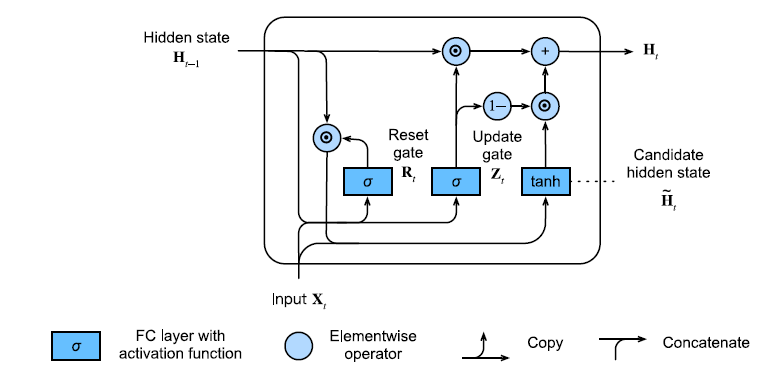

## **Implementation from Scratch**

In [2]:
class GRUScratch(d2l.Module):
  def __init__(self, num_inputs, num_hiddens, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    init_weights = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
    triple = lambda: (init_weights(num_inputs, num_hiddens),
                      init_weights(num_hiddens, num_hiddens),
                      nn.Parameter(torch.zeros(num_hiddens)))

    self.W_xz, self.W_hz, self.b_z = triple() # Update gate
    self.W_xr, self.W_hr, self.b_r = triple() # Reset gate
    self.W_xh, self.W_hh, self.b_h = triple() # Candidate hidden state

  def forward(self, inputs, H=None):
    if H is None:
      # Initial state with shape: (batch_size, num_hiddens)
      H = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
    outputs = []
    for X in inputs:
      Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
                        torch.matmul(H, self.W_hz) + self.b_z)
      R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                        torch.matmul(H, self.W_hr) + self.b_r)
      H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                           torch.matmul(R * H, self.W_hh) + self.b_h)
      H = Z * H + (1 - Z) * H_tilde
      outputs.append(H)
    return outputs, H

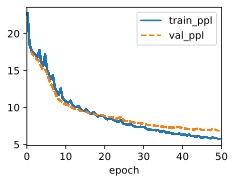

In [3]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [9]:
model.predict("it has", 20, data.vocab, d2l.try_gpu())

'it has heon the the the th'

## **Concise Implementation**

In [5]:
class GRU(d2l.RNN):
  def __init__(self, num_inputs, num_hiddens):
    d2l.Module.__init__(self)
    self.save_hyperparameters()
    self.rnn = nn.GRU(num_inputs, num_hiddens)

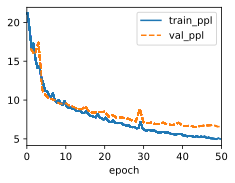

In [10]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [11]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has experent and the th'